# Analyze growth rates of individual clones

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
from scipy.optimize import curve_fit

## Set output parameters

In [3]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/pop_dyn_growth_rates"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [4]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Counts of clone barcodes

Load preprocessed data.

Preprocessing steps (previously done) consist of:
- Call library barcode.
- Error correction of clone barcode by consensus.
- Sum counts for error corrected clone barcode cluster.
- Call genuine barcodes (filtering to remove errors due to PCR and sequencing noise).

In [5]:
infile = "../preprocessed_data/pop_dyn_data/clone_barcodes.tsv.gz"

obs_raw = pd.read_csv(infile, sep="\t", header=0, index_col=None)

print(obs_raw.shape)
obs_raw.head()

(4229949, 11)


,well,library_barcode_call,clone_barcode_consensus,lib,count,time,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics,call_genuine_clone_barcode_fidelity,n_timepoints_seen
0,puro,LB1,AGACAGTGTGACAGTGTGTGACTCTGA,sFH11-1,565,0,supernatant,True,True,False,6
1,puro,LB1,TGAGAGTGTCTGACTCAGTCTCTGTGT,sFH11-1,540,0,supernatant,True,True,False,2
2,puro,LB1,TGTCTGAGTCTGTCTGTGTCACTGTCT,sFH11-1,491,0,supernatant,True,True,False,5
3,puro,LB1,AGAGTCTGACTCACTCAGTGTCTGTCT,sFH11-1,478,0,supernatant,True,True,False,6
4,puro,LB1,ACTGTCTGTCAGACACTCTGTCACTCT,sFH11-1,461,0,supernatant,True,True,False,2


## Counts of spike-in standard for normalization

In [6]:
infile = "../preprocessed_data/pop_dyn_data/counts_spike_in_standard.tsv"

counts_STD = pd.read_csv(infile, sep="\t", index_col=None, header=None)
counts_STD.columns = ["lib", "count"]
counts_STD = counts_STD.set_index("lib")

print(counts_STD.shape)
counts_STD.head()

(27, 1)


,count
lib,
sFH11-1,7660
sFH11-2,24221
sFH11-3,29569
sFH11-4,13359
sFH11-5,2401


# Preprocess data

## Select data used for this analysis

In [7]:
# Drop replicates at final timepoint (which would complicate the analysis by double-counting)
obs_raw = obs_raw.loc[obs_raw["lib"].isin(["sFH11-7", "sFH11-14", "sFH11-21"]) == False]

# Select barcodes flagged as genuine and relevant to this analysis
obs = obs_raw.loc[obs_raw["call_genuine_clone_barcode_dynamics"] == True]

print(obs.shape)
obs.head()

(38669, 11)


,well,library_barcode_call,clone_barcode_consensus,lib,count,time,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics,call_genuine_clone_barcode_fidelity,n_timepoints_seen
0,puro,LB1,AGACAGTGTGACAGTGTGTGACTCTGA,sFH11-1,565,0,supernatant,True,True,False,6
1,puro,LB1,TGAGAGTGTCTGACTCAGTCTCTGTGT,sFH11-1,540,0,supernatant,True,True,False,2
2,puro,LB1,TGTCTGAGTCTGTCTGTGTCACTGTCT,sFH11-1,491,0,supernatant,True,True,False,5
3,puro,LB1,AGAGTCTGACTCACTCAGTGTCTGTCT,sFH11-1,478,0,supernatant,True,True,False,6
4,puro,LB1,ACTGTCTGTCAGACACTCTGTCACTCT,sFH11-1,461,0,supernatant,True,True,False,2


## Fill unobserved counts with zero

In [8]:
%%time

# Construct new dataframe which has a row for every clone and time

obs_full = pd.DataFrame(columns=obs.columns)

for (well, library_barcode_call), group in obs.groupby(["well", "library_barcode_call"]):
    
    # Create index from cross product of well, library_barcode, time, and clone_barcodes for this group
    index = pd.MultiIndex.from_product([obs.well.unique(),
                                        obs.library_barcode_call.unique(),
                                        obs.time.unique(),
                                        group["clone_barcode_consensus"].unique()],
                                       names=["well", "library_barcode_call", "time", "clone_barcode_consensus"])
    
    df_temp = pd.DataFrame(index=index).reset_index()
    obs_full = obs_full.append(df_temp)
    
    obs_full = obs_full.drop_duplicates()  # not sure why duplicate rows are created, but we drop them

obs_full["count"] = 0  # set default count to zero (for unobserved rows)

# Copy values from rows with data
obs_full = obs_full.set_index(["well", "library_barcode_call", "clone_barcode_consensus", "time"])
obs_temp = obs.set_index(["well", "library_barcode_call", "clone_barcode_consensus", "time"])
obs_full.loc[obs_temp.index] = obs_temp

obs_full = obs_full.reset_index()

# Sort index
obs_full = obs_full.sort_index()

# Propagate sequencing library name to rows (required for normalization)

obs_full = obs_full.set_index(["well", "time"])

for (well, time), group in obs.groupby(["well", "time"]):
    assert len(group["lib"].unique()) == 1  # there should only be one lib per well and timepoint
    lib_temp = group["lib"].unique()[0]
    obs_full.loc[(well, time), "lib"] = lib_temp

obs_full = obs_full.reset_index()

# Propagate values for observed rows to rows of new dataframe

obs_full = obs_full.set_index(["well", "library_barcode_call", "clone_barcode_consensus"])

for (well, library_barcode_call, clone_barcode_consensus), group in obs.groupby(["well", "library_barcode_call", "clone_barcode_consensus"]):
    assert len(group["n_timepoints_seen"].unique()) == 1  # there should only be one unique value for number of timepoints seen
    obs_full.loc[(well, library_barcode_call, clone_barcode_consensus), "n_timepoints_seen"] = group["n_timepoints_seen"].unique()[0]

obs_full = obs_full.reset_index()

# Examine dataframe
print(obs_full.shape)
obs_full.head()

# Note that flags and n_timepoints_seen are not propagated. Be careful when using these in obs_full.

/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2472: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = fn(*args, **kwargs)


(526536, 11)
CPU times: user 2min 56s, sys: 547 ms, total: 2min 56s
Wall time: 2min 56s


,well,library_barcode_call,clone_barcode_consensus,time,lib,count,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics,call_genuine_clone_barcode_fidelity,n_timepoints_seen
0,puro,LB1,AGTCACTGTGTGACACTGTGACAGAGA,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN
1,puro,LB1,AGAGTGTGTGTGAGTGACTCAGAGTGT,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN
2,puro,LB1,TGTCAGACTGTCTGAGTGTCTCTGAGT,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN
3,puro,LB1,TGACACACTGTCTGTCACAGACACAGA,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN
4,puro,LB1,TCAGTGAGTGTCACTCAGTCAGTCTGA,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN


## Normalize abundances using spike-in standard

In [9]:
# Normalization yields counts per million of spike-in standard (CPMS)

# Calculate normalization factor by summing counts of standard
counts_STD["norm_factor_cpm_std"] = 1e6/counts_STD["count"]

# Calculate counts per million of standard
obs["cpm_std"] = np.array(obs["count"]) * np.array(counts_STD["norm_factor_cpm_std"].loc[obs["lib"]])

# Analogous calculation for zero-filled dataframe containing zeros for missing values
obs_full["cpm_std"] = np.array(obs_full["count"]) * np.array(counts_STD["norm_factor_cpm_std"].loc[obs_full["lib"]])

/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Substitute pseudocounts

In [10]:
# Set pseudocount
PSEUDOCOUNT = 0.5
PSEUDOCOUNT_CPM_STD = 10

In [11]:
# Replace zero values with pseudocounts
obs_full["count_pseudo"] = obs_full["count"].replace(to_replace=0, value=PSEUDOCOUNT)
obs_full["cpm_std_pseudo"] = obs_full["cpm_std"].replace(to_replace=0, value=PSEUDOCOUNT_CPM_STD)

obs_full.head()

,well,library_barcode_call,clone_barcode_consensus,time,lib,count,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics,call_genuine_clone_barcode_fidelity,n_timepoints_seen,cpm_std,count_pseudo,cpm_std_pseudo
0,puro,LB1,AGTCACTGTGTGACACTGTGACAGAGA,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN,0.0,0.5,10.0
1,puro,LB1,AGAGTGTGTGTGAGTGACTCAGAGTGT,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN,0.0,0.5,10.0
2,puro,LB1,TGTCAGACTGTCTGAGTGTCTCTGAGT,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN,0.0,0.5,10.0
3,puro,LB1,TGACACACTGTCTGTCACAGACACAGA,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN,0.0,0.5,10.0
4,puro,LB1,TCAGTGAGTGTCACTCAGTCAGTCTGA,0,sFH11-1,0,NaN,NaN,NaN,NaN,NaN,0.0,0.5,10.0


## Pivot observations to time traces

In [12]:
# Pivot observations to time traces

obs_pivot = obs.pivot(index=["well", "library_barcode_call", "clone_barcode_consensus"], columns="time", values="cpm_std")

print(obs_pivot.shape)
obs_pivot.head()

(15035, 6)


time                                                                 0   1   2             3             4             5
well    library_barcode_call clone_barcode_consensus                                                                    
no_drug LB1                  AAACTCACAGTCACAGTCTGAGACAGT           NaN NaN NaN  26258.658121           NaN           NaN
                             AAACTGTGACAGAGAGTCTGTCAGTGA           NaN NaN NaN           NaN  95451.993262           NaN
                             AAAGAGACACTCTGACTCTGTCAGTGT           NaN NaN NaN           NaN           NaN  54106.280193
                             AAAGTCAGTCAGACACTGTGAGTCACA           NaN NaN NaN           NaN           NaN  12560.386473
                             AAAGTGTGTGACAGTGTCAGAGTCTCA  76893.576222 NaN NaN           NaN           NaN           NaN

In [13]:
# Pivot observations to time traces for full zero-filled dataframe

obs_full_pivot = obs_full.pivot(index=["well", "library_barcode_call", "clone_barcode_consensus"], columns="time", values="cpm_std")

print(obs_full_pivot.shape)
obs_full_pivot.head()

(87756, 6)


time                                                        0    1    2    3    4    5
well    library_barcode_call clone_barcode_consensus                                  
no_drug LB1                  AAACACACACTGTGAGACTGACAGTCA  0.0  0.0  0.0  0.0  0.0  0.0
                             AAACACACTCAGACAGAGAGACAGACA  0.0  0.0  0.0  0.0  0.0  0.0
                             AAACACAGACTGAGTGACTCTCACACA  0.0  0.0  0.0  0.0  0.0  0.0
                             AAACACAGAGTCAGAGAGTCTGTGTCA  0.0  0.0  0.0  0.0  0.0  0.0
                             AAACACTCTGTCAGAGAGAGAGAGAGA  0.0  0.0  0.0  0.0  0.0  0.0

## Create annotated time trace tables

In [14]:
# Annotate time traces with number of timepoints seen
obs_pivot_ann = obs_pivot.copy()
obs_pivot_ann["n_timepoints_seen"] = np.count_nonzero(~np.isnan(obs_pivot_ann),axis=1)
obs_pivot_ann["n_timepoints_seen_as_categorical"] = pd.Categorical(obs_pivot_ann["n_timepoints_seen"])

obs_pivot_ann.head()

time                                                                 0   1   2             3             4             5  n_timepoints_seen n_timepoints_seen_as_categorical
well    library_barcode_call clone_barcode_consensus                                                                                                                        
no_drug LB1                  AAACTCACAGTCACAGTCTGAGACAGT           NaN NaN NaN  26258.658121           NaN           NaN                  1                                1
                             AAACTGTGACAGAGAGTCTGTCAGTGA           NaN NaN NaN           NaN  95451.993262           NaN                  1                                1
                             AAAGAGACACTCTGACTCTGTCAGTGT           NaN NaN NaN           NaN           NaN  54106.280193                  1                                1
                             AAAGTCAGTCAGACACTGTGAGTCACA           NaN NaN NaN           NaN           NaN  12560.386473                  1                                1
                             AAAGTGTGTGACAGTGTCAGAGTCTCA  76893.576222 NaN NaN           NaN           NaN           NaN                  1                                1

In [15]:
obs_full_pivot_ann = obs_full_pivot.copy()
obs_full_pivot_ann["n_timepoints_seen"] = np.count_nonzero(obs_full_pivot_ann,axis=1)
obs_full_pivot_ann["n_timepoints_seen_as_categorical"] = pd.Categorical(obs_full_pivot_ann["n_timepoints_seen"])

obs_full_pivot_ann.head()

time                                                        0    1    2    3    4    5  n_timepoints_seen n_timepoints_seen_as_categorical
well    library_barcode_call clone_barcode_consensus                                                                                      
no_drug LB1                  AAACACACACTGTGAGACTGACAGTCA  0.0  0.0  0.0  0.0  0.0  0.0                  0                                0
                             AAACACACTCAGACAGAGAGACAGACA  0.0  0.0  0.0  0.0  0.0  0.0                  0                                0
                             AAACACAGACTGAGTGACTCTCACACA  0.0  0.0  0.0  0.0  0.0  0.0                  0                                0
                             AAACACAGAGTCAGAGAGTCTGTGTCA  0.0  0.0  0.0  0.0  0.0  0.0                  0                                0
                             AAACACTCTGTCAGAGAGAGAGAGAGA  0.0  0.0  0.0  0.0  0.0  0.0                  0                                0

# Fit growth model to clone dynamics

In [16]:
# Fill missing values with zero

for t in [0, 1, 2, 3, 4, 5]:
    obs_pivot_ann[t] = obs_pivot_ann[t].fillna(0)

obs_pivot_ann.head()

time                                                                 0    1    2             3             4             5  n_timepoints_seen n_timepoints_seen_as_categorical
well    library_barcode_call clone_barcode_consensus                                                                                                                          
no_drug LB1                  AAACTCACAGTCACAGTCTGAGACAGT      0.000000  0.0  0.0  26258.658121      0.000000      0.000000                  1                                1
                             AAACTGTGACAGAGAGTCTGTCAGTGA      0.000000  0.0  0.0      0.000000  95451.993262      0.000000                  1                                1
                             AAAGAGACACTCTGACTCTGTCAGTGT      0.000000  0.0  0.0      0.000000      0.000000  54106.280193                  1                                1
                             AAAGTCAGTCAGACACTGTGAGTCACA      0.000000  0.0  0.0      0.000000      0.000000  12560.386473                  1                                1
                             AAAGTGTGTGACAGTGTCAGAGTCTCA  76893.576222  0.0  0.0      0.000000      0.000000      0.000000                  1                                1

In [17]:
%%time

# Initial parameter guesses for fit

a_guess = 10000
k_guess = 0

# Create columns for fits

obs_pivot_ann["a_fit"] = np.nan
obs_pivot_ann["k_fit"] = np.nan
obs_pivot_ann["a_var_fit"] = np.nan
obs_pivot_ann["k_var_fit"] = np.nan

# Fit model

for index, row in obs_pivot_ann.iterrows():
    
    t = tuple(np.arange(0, 6))
    y = tuple([row[i] for i in t])
    
    # Fit the function a * np.exp(k * t) + b to x and y
    try:
        popt, pcov = curve_fit(lambda t, a, k: a * np.exp(k * t), t, y, p0=(a_guess, k_guess))
    except RuntimeError:
        popt = None
        pcov = None
    
    if (popt is not None) and (pcov is not None):
        
        a = popt[0]
        k = popt[1]

        a_var = pcov[0,0]
        k_var = pcov[1,1]
        
        # Calculate residuals, R squared
        y_fitted = a * np.exp(k * np.array(t))
        residuals = y - y_fitted
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
    else:
        
        a = np.nan
        k = np.nan
        
        a_var = np.nan
        k_var = np.nan
        
        ss_res = np.nan
        ss_tot = np.nan
        r_squared = np.nan
    
    obs_pivot_ann.loc[index, "a_fit"] = a
    obs_pivot_ann.loc[index, "k_fit"] = k
    obs_pivot_ann.loc[index, "a_var_fit"] = a_var
    obs_pivot_ann.loc[index, "k_var_fit"] = k_var
    obs_pivot_ann.loc[index, "ss_res"] = ss_res
    obs_pivot_ann.loc[index, "ss_tot"] = ss_tot
    obs_pivot_ann.loc[index, "r_squared"] = r_squared

CPU times: user 1min 32s, sys: 32 ms, total: 1min 32s
Wall time: 1min 32s


In [18]:
# Calculate summary statistics
obs_pivot_ann["a_sd_fit"] = np.sqrt(obs_pivot_ann["a_var_fit"])
obs_pivot_ann["k_sd_fit"] = np.sqrt(obs_pivot_ann["k_var_fit"])

obs_pivot_ann["a_cv_fit"] = obs_pivot_ann["a_sd_fit"] / obs_pivot_ann["a_fit"]
obs_pivot_ann["k_cv_fit"] = obs_pivot_ann["k_sd_fit"] / obs_pivot_ann["k_fit"]

In [19]:
# Log-transform fitted parameters
obs_pivot_ann["log10_a_var_fit"] = np.log10(obs_pivot_ann["a_var_fit"])
obs_pivot_ann["log10_k_var_fit"] = np.log10(obs_pivot_ann["k_var_fit"])

obs_pivot_ann["log10_a_sd_fit"] = np.log10(obs_pivot_ann["a_sd_fit"])
obs_pivot_ann["log10_k_sd_fit"] = np.log10(obs_pivot_ann["k_sd_fit"])

obs_pivot_ann["log10_ss_res"] = np.log10(obs_pivot_ann["ss_res"])

# Bound growth rates based on limit of detection

## Censor observed values based on limit of detection

In [20]:
# Substitute missing values with pseudocount for limit of detection

# Find normalization factor to determine appropriate pseudocount (for a single read, equivalent to limit of detection)
norm_factor_by_lib = obs_raw[["lib", "well", "time"]].drop_duplicates().set_index("lib").join(counts_STD)
libs_to_drop = ["sFH12-9", "sFH12-10", "sFH12-11", "sFH12-12", "sFH12-13", "sFH12-14"]
norm_factor_by_lib = norm_factor_by_lib.drop(libs_to_drop)
norm_factor_by_lib = norm_factor_by_lib.set_index(["well", "time"])
norm_factor_by_lib

count  norm_factor_cpm_std
well    time                            
puro    0      7660           130.548303
        1     24221            41.286487
        2     29569            33.819203
        3     13359            74.855902
        4      2401           416.493128
        5      2016           496.031746
zeo     0     20619            48.498957
        1     17361            57.600369
        2      6303           158.654609
        3     10490            95.328885
        4      1016           984.251969
        5      1075           930.232558
no_drug 0      5215           191.754554
        1      4576           218.531469
        2      6601           151.492198
        3      9673           103.380544
        4      5343           187.160771
        5      1035           966.183575

In [21]:
# Copy dataframe
obs_pivot_ann_censored = obs_pivot_ann.copy()

# Substitute pseudocount
for _well in ["puro", "zeo", "no_drug"]:
    for _time in [0, 1, 2, 3, 4, 5]:
        obs_pivot_ann_censored.loc[_well, _time].loc[obs_pivot_ann_censored.loc[_well, _time] == 0] = norm_factor_by_lib.loc[_well, _time]["norm_factor_cpm_std"]
        
obs_pivot_ann_censored.head()

/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


time                                                                 0           1           2             3             4             5  n_timepoints_seen n_timepoints_seen_as_categorical        a_fit     k_fit     a_var_fit  k_var_fit        ss_res        ss_tot  r_squared      a_sd_fit  k_sd_fit  a_cv_fit  k_cv_fit  log10_a_var_fit  log10_k_var_fit  log10_a_sd_fit  log10_k_sd_fit  log10_ss_res
well    library_barcode_call clone_barcode_consensus                                                                                                                                                                                                                                                                                                                                                           
no_drug LB1                  AAACTCACAGTCACAGTCTGAGACAGT    191.754554  218.531469  151.492198  26258.658121    187.160771    966.183575                  1                                1  3516.719167  0.087320  6.254329e+07   0.430055  5.695179e+08  5.745976e+08   0.008840   7908.431577  0.655786  2.248810  7.510116         7.796181        -0.366476        3.898090       -0.183238      8.755507
                             AAACTGTGACAGAGAGTCTGTCAGTGA    191.754554  218.531469  151.492198    103.380544  95451.993262    966.183575                  1                                1  6903.045535  0.314799  3.881615e+08   0.463388  6.790017e+09  7.592569e+09   0.105702  19701.813675  0.680726  2.854076  2.162416         8.589012        -0.334055        4.294506       -0.167028      9.831871
                             AAAGAGACACTCTGACTCTGTCAGTGT    191.754554  218.531469  151.492198    103.380544    187.160771  54106.280193                  1                                1          NaN       NaN           NaN        NaN           NaN           NaN        NaN           NaN       NaN       NaN       NaN              NaN              NaN             NaN             NaN           NaN
                             AAAGTCAGTCAGACACTGTGAGTCACA    191.754554  218.531469  151.492198    103.380544    187.160771  12560.386473                  1                                1          NaN       NaN           NaN        NaN           NaN           NaN        NaN           NaN       NaN       NaN       NaN              NaN              NaN             NaN             NaN           NaN
                             AAAGTGTGTGACAGTGTCAGAGTCTCA  76893.576222  218.531469  151.492198    103.380544    187.160771    966.183575                  1                                1          NaN       NaN           NaN        NaN           NaN           NaN        NaN           NaN       NaN       NaN       NaN              NaN              NaN             NaN             NaN           NaN

In [22]:
%%time

# Initial parameter guesses for fit

a_guess = 10000
k_guess = 0

# Fit model

for index, row in obs_pivot_ann_censored.iterrows():
    
    t = tuple(np.arange(0, 6))
    y = tuple([row[i] for i in t])
    
    # Fit the function a * np.exp(k * t) + b to x and y
    try:
        popt, pcov = curve_fit(lambda t, a, k: a * np.exp(k * t), t, y, p0=(a_guess, k_guess))
    except RuntimeError:
        popt = None
        pcov = None
    
    if (popt is not None) and (pcov is not None):
        
        a = popt[0]
        k = popt[1]

        a_var = pcov[0,0]
        k_var = pcov[1,1]
        
        # Calculate residuals, R squared
        y_fitted = a * np.exp(k * np.array(t))
        residuals = y - y_fitted
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
    else:
        
        a = np.nan
        k = np.nan
        
        a_var = np.nan
        k_var = np.nan
        
        ss_res = np.nan
        ss_tot = np.nan
        r_squared = np.nan
    
    obs_pivot_ann_censored.loc[index, "a_fit_censored"] = a
    obs_pivot_ann_censored.loc[index, "k_fit_censored"] = k
    obs_pivot_ann_censored.loc[index, "a_var_fit_censored"] = a_var
    obs_pivot_ann_censored.loc[index, "k_var_fit_censored"] = k_var
    obs_pivot_ann_censored.loc[index, "ss_res_censored"] = ss_res
    obs_pivot_ann_censored.loc[index, "ss_tot_censored"] = ss_tot
    obs_pivot_ann_censored.loc[index, "r_squared_censored"] = r_squared

CPU times: user 1min 15s, sys: 32 ms, total: 1min 15s
Wall time: 1min 15s


In [23]:
# Calculate summary statistics
obs_pivot_ann_censored["a_sd_fit_censored"] = np.sqrt(obs_pivot_ann_censored["a_var_fit_censored"])
obs_pivot_ann_censored["k_sd_fit_censored"] = np.sqrt(obs_pivot_ann_censored["k_var_fit_censored"])

obs_pivot_ann_censored["a_cv_fit_censored"] = obs_pivot_ann_censored["a_sd_fit_censored"] / obs_pivot_ann_censored["a_fit_censored"]
obs_pivot_ann_censored["k_cv_fit_censored"] = obs_pivot_ann_censored["k_sd_fit_censored"] / obs_pivot_ann_censored["k_fit_censored"]

In [24]:
# Log-transform fitted parameters
obs_pivot_ann_censored["log10_a_var_fit_censored"] = np.log10(obs_pivot_ann_censored["a_var_fit_censored"])
obs_pivot_ann_censored["log10_k_var_fit_censored"] = np.log10(obs_pivot_ann_censored["k_var_fit_censored"])

obs_pivot_ann_censored["log10_a_sd_fit_censored"] = np.log10(obs_pivot_ann_censored["a_sd_fit_censored"])
obs_pivot_ann_censored["log10_k_sd_fit_censored"] = np.log10(obs_pivot_ann_censored["k_sd_fit_censored"])

obs_pivot_ann_censored["log10_ss_res_censored"] = np.log10(obs_pivot_ann_censored["ss_res_censored"])

# Plot distribution of growth rates

## Set plot parameters

In [25]:
# Set colors
palette = ["#9e9ac8", "#74c476"]

In [26]:
# Calculate growth rate k based on observed cell doubling time (14 h)
K_DOUBLING_TIME = np.log(2)/(14/24)
print(K_DOUBLING_TIME)

1.1882523095313346


In [66]:
CUTOFF_R_SQUARED = 0.9
CUTOFF_N_TIMEPOINTS_SEEN = 2

## Plot growth rates under puromycin selection

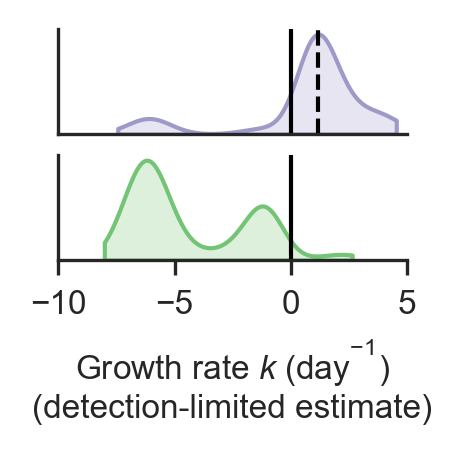

In [67]:
fig, axes = plt.subplots(2, 1, figsize=(1.5,1))

ax = axes[0]

selector = (obs_pivot_ann_censored["n_timepoints_seen"] >= CUTOFF_N_TIMEPOINTS_SEEN) & (obs_pivot_ann_censored["r_squared_censored"] > CUTOFF_R_SQUARED)
data_subset = obs_pivot_ann_censored.loc[selector]
data_subset = data_subset.loc["puro", "LB1"]

sns.kdeplot(ax=ax, data=data_subset, x="k_fit_censored",
            cut=0,
            color=palette[0], fill=True)

ax.axvline(x=K_DOUBLING_TIME, color="k", ls="--", lw=1)

ax = axes[1]

selector = (obs_pivot_ann_censored["n_timepoints_seen"] >= CUTOFF_N_TIMEPOINTS_SEEN) & (obs_pivot_ann_censored["r_squared_censored"] > CUTOFF_R_SQUARED)
data_subset = obs_pivot_ann_censored.loc[selector]
data_subset = data_subset.loc["puro", "LB2"]

sns.kdeplot(ax=ax, data=data_subset, x="k_fit_censored",
            cut=0,
            color=palette[1], fill=True)


for ax in axes:
    ax.set_xlim(-10, 5)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axvline(x=0, color="k", ls="-", lw=1)
    sns.despine()

axes[-1].set_xlabel(r"Growth rate $k$ (day$^{-1}$)" + "\n(detection-limited estimate)")
axes[-1].set_xticks([-10, -5, 0, 5])

save_figure(fig, "stacked_kde_puro_censored")

## Plot growth rates under zeocin selection

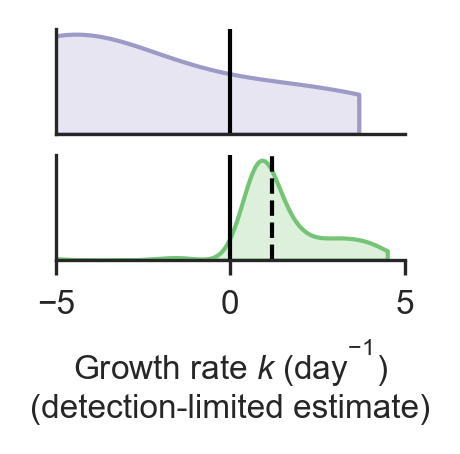

In [68]:
CUTOFF_R_SQUARED = 0.9

fig, axes = plt.subplots(2, 1, figsize=(1.5,1))

ax = axes[0]

selector = (obs_pivot_ann_censored["n_timepoints_seen"] >= CUTOFF_N_TIMEPOINTS_SEEN) & (obs_pivot_ann_censored["r_squared_censored"] > CUTOFF_R_SQUARED)
data_subset = obs_pivot_ann_censored.loc[selector]
data_subset = data_subset.loc["zeo", "LB1"]

sns.kdeplot(ax=ax, data=data_subset, x="k_fit_censored",
            cut=0,
            color=palette[0], fill=True)


ax = axes[1]

selector = (obs_pivot_ann_censored["n_timepoints_seen"] >= CUTOFF_N_TIMEPOINTS_SEEN) & (obs_pivot_ann_censored["r_squared_censored"] > CUTOFF_R_SQUARED)
data_subset = obs_pivot_ann_censored.loc[selector]
data_subset = data_subset.loc["zeo", "LB2"]

sns.kdeplot(ax=ax, data=data_subset, x="k_fit_censored",
            cut=0,
            color=palette[1], fill=True)

ax.axvline(x=K_DOUBLING_TIME, color="k", ls="--", lw=1)

for ax in axes:
    ax.set_xlim(-5, 5)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axvline(x=0, color="k", ls="-", lw=1)
    sns.despine()

axes[-1].set_xlabel(r"Growth rate $k$ (day$^{-1}$)" + "\n(detection-limited estimate)")
axes[-1].set_xticks([-5, 0, 5])

save_figure(fig, "stacked_kde_zeo_censored")

## Plot growth rates without selection

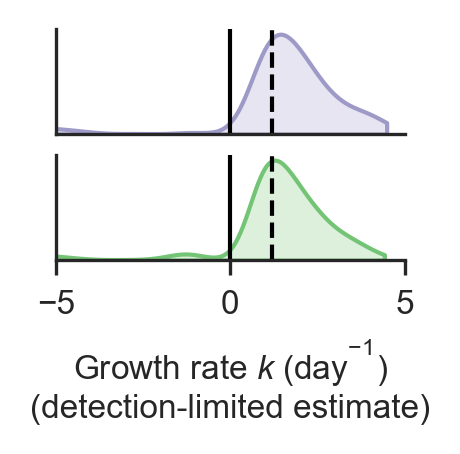

In [69]:
CUTOFF_R_SQUARED = 0.9

fig, axes = plt.subplots(2, 1, figsize=(1.5,1))

ax = axes[0]

selector = (obs_pivot_ann_censored["n_timepoints_seen"] >= CUTOFF_N_TIMEPOINTS_SEEN) & (obs_pivot_ann_censored["r_squared_censored"] > CUTOFF_R_SQUARED)
data_subset = obs_pivot_ann_censored.loc[selector]
data_subset = data_subset.loc["no_drug", "LB1"]

sns.kdeplot(ax=ax, data=data_subset, x="k_fit_censored",
            cut=0,
            color=palette[0], fill=True)


ax = axes[1]

selector = (obs_pivot_ann_censored["n_timepoints_seen"] >= CUTOFF_N_TIMEPOINTS_SEEN) & (obs_pivot_ann_censored["r_squared_censored"] > CUTOFF_R_SQUARED)
data_subset = obs_pivot_ann_censored.loc[selector]
data_subset = data_subset.loc["no_drug", "LB2"]

sns.kdeplot(ax=ax, data=data_subset, x="k_fit_censored",
            cut=0,
            color=palette[1], fill=True)


for ax in axes:
    ax.set_xlim(-5, 5)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axvline(x=0, color="k", ls="-", lw=1)
    ax.axvline(x=K_DOUBLING_TIME, color="k", ls="--", lw=1)
    sns.despine()

axes[-1].set_xlabel(r"Growth rate $k$ (day$^{-1}$)" + "\n(detection-limited estimate)")
axes[-1].set_xticks([-5, 0, 5])

save_figure(fig, "stacked_kde_no_drug_censored")

# Plot examples of fitted curves

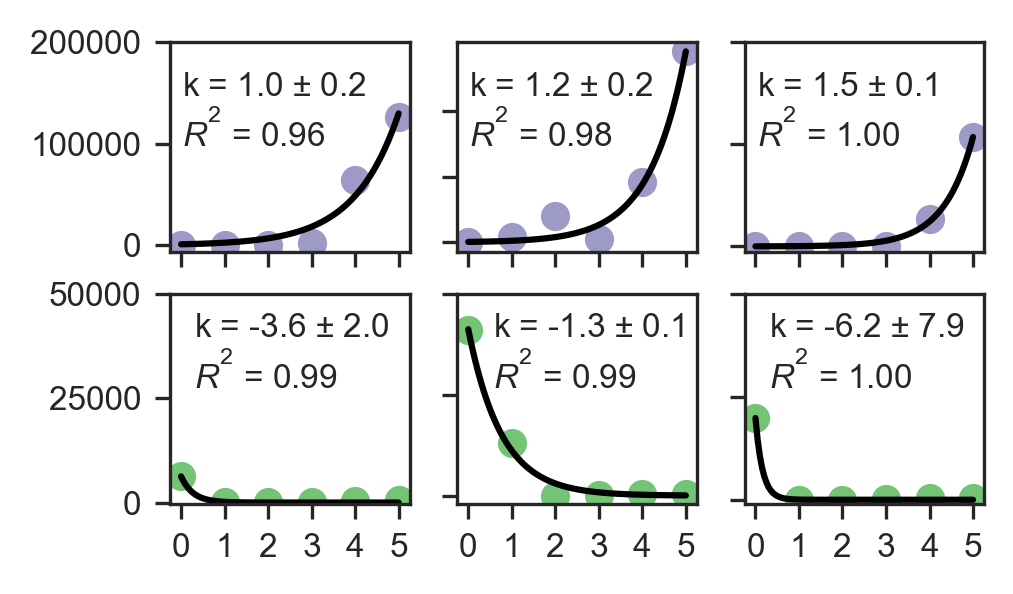

In [70]:
random_seed = 0

x = [0, 1, 2, 3, 4, 5]

fig, axes = plt.subplots(2, 3, figsize=(3.5,2), sharex=True, sharey=False)


# Resistant population

selector = (obs_pivot_ann_censored["n_timepoints_seen"] >= CUTOFF_N_TIMEPOINTS_SEEN) & (obs_pivot_ann_censored["r_squared_censored"] > CUTOFF_R_SQUARED)
data_subset = obs_pivot_ann_censored.loc[selector]
data_subset = data_subset.loc["puro", "LB1"]
data_subset = data_subset.sample(n=3, random_state=random_seed)


# Clone 1
ax = axes[0,0]
i = 0

y = [data_subset.iloc[i][j] for j in x]

k = data_subset.iloc[i]["k_fit_censored"]
k_var = data_subset.iloc[i]["k_var_fit_censored"]
a = data_subset.iloc[i]["a_fit_censored"]
r_squared_censored = data_subset.iloc[i]["r_squared_censored"]

x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = a * np.exp(k*x_fitted)

ax.scatter(x, y, c=palette[0])
ax.plot(x_fitted, y_fitted, marker=None, color="k")

k_std = np.sqrt(k_var)
text = "k = {k:.1f} $\pm$ {k_std:.1f}\n$R^2$ = {r_squared_censored:.2f}".format(k = k, k_std = k_std, r_squared_censored=r_squared_censored)
ax.text(0.05, 0.5, text, transform=ax.transAxes)


# Clone 2
ax = axes[0,1]
i = 1

y = [data_subset.iloc[i][j] for j in x]

k = data_subset.iloc[i]["k_fit_censored"]
k_var = data_subset.iloc[i]["k_var_fit_censored"]
a = data_subset.iloc[i]["a_fit_censored"]
r_squared_censored = data_subset.iloc[i]["r_squared_censored"]

x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = a * np.exp(k*x_fitted)

ax.scatter(x, y, c=palette[0])
ax.plot(x_fitted, y_fitted, marker=None, color="k")

k_std = np.sqrt(k_var)
text = "k = {k:.1f} $\pm$ {k_std:.1f}\n$R^2$ = {r_squared_censored:.2f}".format(k = k, k_std = k_std, r_squared_censored=r_squared_censored)
ax.text(0.05, 0.5, text, transform=ax.transAxes)


# Clone 3
ax = axes[0,2]
i = 2

y = [data_subset.iloc[i][j] for j in x]

k = data_subset.iloc[i]["k_fit_censored"]
k_var = data_subset.iloc[i]["k_var_fit_censored"]
a = data_subset.iloc[i]["a_fit_censored"]
r_squared_censored = data_subset.iloc[i]["r_squared_censored"]

x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = a * np.exp(k*x_fitted)

ax.scatter(x, y, c=palette[0])
ax.plot(x_fitted, y_fitted, marker=None, color="k")

k_std = np.sqrt(k_var)
text = "k = {k:.1f} $\pm$ {k_std:.1f}\n$R^2$ = {r_squared_censored:.2f}".format(k = k, k_std = k_std, r_squared_censored=r_squared_censored)
ax.text(0.05, 0.5, text, transform=ax.transAxes)


# Sensitive population

selector = (obs_pivot_ann_censored["n_timepoints_seen"] >= CUTOFF_N_TIMEPOINTS_SEEN) & (obs_pivot_ann_censored["r_squared_censored"] > CUTOFF_R_SQUARED)
data_subset = obs_pivot_ann_censored.loc[selector]
data_subset = data_subset.loc["puro", "LB2"]
data_subset = data_subset.sample(n=3, random_state=random_seed)


# Clone 1
ax = axes[1,0]
i = 0

y = [data_subset.iloc[i][j] for j in x]

k = data_subset.iloc[i]["k_fit_censored"]
k_var = data_subset.iloc[i]["k_var_fit_censored"]
a = data_subset.iloc[i]["a_fit_censored"]
r_squared_censored = data_subset.iloc[i]["r_squared_censored"]

x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = a * np.exp(k*x_fitted)

ax.scatter(x, y, c=palette[1])
ax.plot(x_fitted, y_fitted, marker=None, color="k")

k_std = np.sqrt(k_var)
text = "k = {k:.1f} $\pm$ {k_std:.1f}\n$R^2$ = {r_squared_censored:.2f}".format(k = k, k_std = k_std, r_squared_censored=r_squared_censored)
ax.text(0.1, 0.55, text, transform=ax.transAxes)


# Clone 2
ax = axes[1,1]
i = 1

y = [data_subset.iloc[i][j] for j in x]

k = data_subset.iloc[i]["k_fit_censored"]
k_var = data_subset.iloc[i]["k_var_fit_censored"]
a = data_subset.iloc[i]["a_fit_censored"]
r_squared_censored = data_subset.iloc[i]["r_squared_censored"]

x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = a * np.exp(k*x_fitted)

ax.scatter(x, y, c=palette[1])
ax.plot(x_fitted, y_fitted, marker=None, color="k")

k_std = np.sqrt(k_var)
text = "k = {k:.1f} $\pm$ {k_std:.1f}\n$R^2$ = {r_squared_censored:.2f}".format(k = k, k_std = k_std, r_squared_censored=r_squared_censored)
ax.text(0.15, 0.55, text, transform=ax.transAxes)


# Clone 3
ax = axes[1,2]
i = 2

y = [data_subset.iloc[i][j] for j in x]

k = data_subset.iloc[i]["k_fit_censored"]
k_var = data_subset.iloc[i]["k_var_fit_censored"]
a = data_subset.iloc[i]["a_fit_censored"]
r_squared_censored = data_subset.iloc[i]["r_squared_censored"]

x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = a * np.exp(k*x_fitted)

ax.scatter(x, y, c=palette[1])
ax.plot(x_fitted, y_fitted, marker=None, color="k")

k_std = np.sqrt(k_var)
text = "k = {k:.1f} $\pm$ {k_std:.1f}\n$R^2$ = {r_squared_censored:.2f}".format(k = k, k_std = k_std, r_squared_censored=r_squared_censored)
ax.text(0.1, 0.55, text, transform=ax.transAxes)

for ax in axes.flatten():
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_yticklabels([])

for ax in axes[0,:]:
    ax.set_yticks([0, 100000, 200000])

for ax in axes[1,:]:
    ax.set_yticks([0, 25000, 50000])
    
axes[0,0].set_yticklabels([0, 100000, 200000])
axes[1,0].set_yticklabels([0, 25000, 50000])
    
save_figure(fig, "example_fits_puro_censored")